In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

np.random.seed(42)

# Create dataframe from csv
df = pd.read_csv("./table9.csv", sep=";")
columns = ["Measure2", "Measure3", "Measure4"]
for col in columns:
    df[col] = df[col].replace(regex={',': '.'}).astype(float)

# Assignment 8

## Context 
Analyse the data samples in Table 9 and find a suitable method for approximating the probability distributions of the samples. Motivate the choice of method, identify the likely distributions, and discuss the validity of the selected method.

### Choice of method
The first step is to find which type of data it is. The data is classified in four categories: *Nominal data*, *Ordinal data*, *Discrete data* and *Continuous data* [1]. I would say the data in Table 6 is quantitative, since it can be counted and measured. Further, the data and both discrete and continuous. The column **Measure1** is discrete as it is integers and the other data, **Measure2-4** are float values and therefore continuous. 


In [5]:
df.head()

,Observation,Measure1,Measure2,Measure3,Measure4
0,1,1,2.811,-1.385,54.151
1,2,2,10.357,0.038,70.440
2,3,3,4.970,-0.763,75.764
3,4,2,12.147,0.212,69.844
4,5,2,36.921,1.426,61.136


To choose an appropriate method for approximating the probability distributions, I chose first to find suitable distribution tests for the data. The column with discrete data, **Measure1** seems to be *Poisson distribution*, since I believe the data is countable [3]. For the other columns with data, the continuous data, I used the "fitter" library<a name="cite_ref-1"></a>[<sup>[1]</sup>](#https://fitter.readthedocs.io/en/latest/#) in Python. This library is used for fitting probability distributions to data. 

To measure how good the fits are, the goodness-of-fit test Kolmogorov-Smirnov (KS) is used for the continuous data and is the built-in standard for the Fitter package. Chi-squared goodness-if-fit test is used for the discrete data. Both tests compares the data with a reference distribution and determines whether they share the same distribution [2], [3]. The null hypothesis, H0, for both tests is that there are no difference between the data and they come from the same distribution.

#### The discrete data
For "Measure1" I used the poisson <a name="cite_ref-2"></a>[<sup>[2]</sup>](#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.poisson.html) and chisquare <a name="cite_ref-3"></a>[<sup>[3]</sup>](#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html) packages from the scipy.stats libraries in Python.

In [321]:
data = df["Measure1"].values
mean = np.mean(data)
variance = np.var(data)
values, counts = np.unique(data, return_counts=True)
expected_frequencies = np.array([stats.poisson.pmf(k, mean) * len(data) for k in values])
expected_frequencies *= counts.sum() / expected_frequencies.sum()
chi2_stat, p_value = stats.chisquare(counts, f_exp=expected_frequencies)
print("Chi-squared p-value:", stats.chisquare(counts, f_exp=expected_frequencies).pvalue)

Chi-squared p-value: 0.6392641260680711


The above result, a p-value of **0.639** shows that the p-value is larger than 0.05 and the H0 is not rejected. The data follows a Poisson distribution.

#### The continuous data

The first step for the rest of the data was to print histograms of the data to visualize the distributions. 

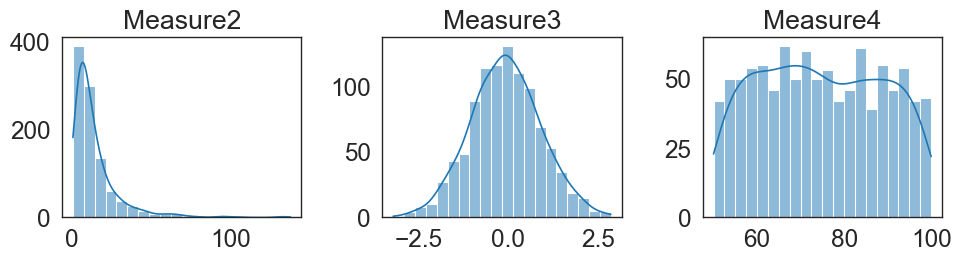

In [344]:
columns = ["Measure2", "Measure3", "Measure4"]

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
axes = axes.flatten()
for i, col in enumerate(columns):
    sns.histplot(data=df, x=col, kde=True, ax=axes[i], bins=20)
    axes[i].set_title(col.title())
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    
plt.tight_layout()
plt.show()

From the Fitter package, I then printed the 10 most common distributions and selected the distributions suitable for the different data.  

In [333]:
from fitter import Fitter, get_common_distributions

", ".join(get_common_distributions())

'cauchy, chi2, expon, exponpow, gamma, lognorm, norm, powerlaw, rayleigh, uniform'

When analyzing the histograms and the data, it seems that **Measure2** is rightskewed and probably follows a lognormal distribution [4]. **Measure3** seems to follow a normal distribution, the bell shape and **Measure4** seems to follow a continuous uniform distribution [4]. The next step was to create the lists containing the distributions to use with Fitter for the data. I chose to use all tests for **Measure1** and **Measure3**. **Measure2** have negative values so for that test, I removed the *lognormal* distribution since it can not contain negative values [5].

In [331]:
measure3_dists = get_common_distributions()
measure3_dists.remove("lognorm")

In [ ]:
f2 = Fitter(df["Measure2"], distributions=get_common_distributions())
f3 = Fitter(df["Measure3"], distributions=measure3_dists)
f4 = Fitter(df["Measure4"], distributions=get_common_distributions())
f2.fit(), f3.fit(), f4.fit()

To get the five best best distributions together with a histogram, I use the built-in function *summary*. 

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,0.000360,1423.118736,1437.842002,inf,0.012314,9.977083e-01
gamma,0.001766,1649.605653,1664.328919,inf,0.067572,2.052723e-04
chi2,0.001873,1633.143452,1647.866718,inf,0.067433,2.131534e-04
expon,0.003418,1534.592708,1544.408219,inf,0.070177,9.984051e-05
cauchy,0.003534,1452.840245,1462.655755,inf,0.172996,1.218502e-26


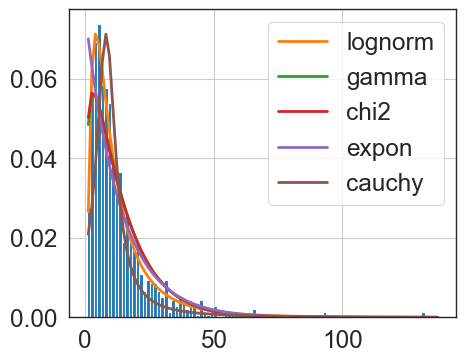

In [336]:
plt.figure(figsize=(5,4))
f2.summary()

The result is similar for the data in the column **Measure2**. Here the best distribution is **lognorm**, which is normal for rightskewed data [4]. The p-value is larger than 0.05 (9.977083e-01 = 0.9977083), which indicates H0 not to be rejected and the large value means it is a very good match. The low **sumsquare_error** also indicates that the distributions is a good fit.

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gamma,0.201299,507.368149,522.091415,inf,0.012710,0.996405
norm,0.202587,504.039121,513.854631,inf,0.013833,0.989585
chi2,0.209979,512.129131,526.852396,inf,0.028994,0.362936
exponpow,0.417287,495.284103,510.007369,inf,0.059244,0.001712
cauchy,0.508765,496.907842,506.723353,inf,0.075705,0.000020


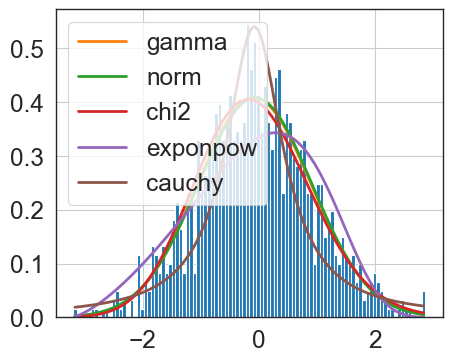

In [337]:
plt.figure(figsize=(5,4))
f3.summary()

For **Measure3**, the best fit is the **gamma** distribution. With a p-value larger than 0.05, the null hypothesis is not rejected and it is a very good fit for the data. The result also shows that the **gamma** and **norm** distributions have very similar values overall so I think both distributions are equally valid. Regarding the sum of squared errors, **chi2** are almost equally close as the top two, but its p-value is a lot smaller. 

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
uniform,0.003512,785.936053,795.751563,0.048151,0.025790,0.510773
powerlaw,0.003559,788.051099,802.774365,0.048752,0.025525,0.524123
rayleigh,0.007012,816.521246,826.336756,0.100227,0.073818,0.000035
chi2,0.007730,823.697970,838.421236,0.110041,0.070009,0.000105
lognorm,0.007817,823.527968,838.251234,0.110629,0.063763,0.000561


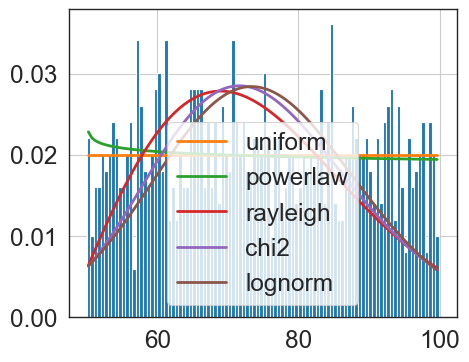

In [338]:
plt.figure(figsize=(5,4))
f4.summary()

For **Measure4**, the result shows that the **uniform** distribution is the best fit. The p-value is larger than 0.05 and H0 is not rejected, meaning it is a good fit. 

## References

[1] Great Learning Editorial Team, (Nov 2023), “4 Types Of Data – Nominal, Ordinal, Discrete and Continuous”. Accessed on: Nov. 14, 2024. [Online]. Available: https://www.mygreatlearning.com/blog/types-of-data/

[2] “Kolmogorov-Smirnov Goodness of Fit Test”. Accessed on: Nov. 17, 2024. [Online]. Available: https://www.statisticshowto.com/kolmogorov-smirnov-test/

[3] J. Frost, “Goodness-of-Fit Tests for Discrete Distributions”. Accessed on: Nov. 20, 2024. [Online]. Available: https://statisticsbyjim.com/hypothesis-testing/goodness-fit-tests-discrete-distributions/

[4] S. Turney, (Jun 2022), “Probability Distribution | Formula, Types, & Examples”. Accessed on: Nov. 14, 2024. [Online]. Available: https://www.scribbr.com/statistics/probability-distributions/

[5] CFI Team, “Lognormal Distribution”. Accessed on: Nov. 17, 2024. [Online]. Available: https://corporatefinanceinstitute.com/resources/data-science/lognormal-distribution/






